# Semi-Supervised GAN 
## Keras Implementations Using MNIST Handwritten Numbers Dataset

### Introducing Semi-Supervised GAN
Semi-supervised learning is one of the most promising areas of practical applications of GANs. Unlike unsupervised learning, in which we need a label for every example in our dataset, and unsupervised learning, in which no labels are used, semi-supervised learning has a class label for only a small subset of training dataset. By internalising hidden structures in the data, semi-supervised learning strives to generalize from the small subnet of labeled data points to effectively classify,  new, previously unseen examples. Importantly, for semi-supervised learning to work, the labled and unlabeled data must come from the same underlying distribution.

Semi-supervised learning aims to address the problem of learning from ever-smaller quantities of labeled data.  In a 2016 study a semi-supervised GAN achieved overall accuracy of labelling unlabeled dataset remarkably close to the fully supervised benchmark, while using fewer than 3% of the labels for training.

### Theory
Semi-supervised GAN (SGAN) is a Generative Adversarial Network whose Discriminator is a multiclass classifier. Instead of distinguishing between only two classes (real and fake). it learns to distinguish between N + 1 classes, where N is the number of classes in the training dataset, with one added for the fake examples produced by the Generator. 

In this implementation the output of the SGAN Discriminator will be represented as a vector of 10 class probabilities (that sum up to 1.0) plus another probability that represents whether the image is real or fake.

### Architecture

In this implementation, the Generator takes in a random noise vector z and produces a fake example x*. The Discriminator receives three kinds of data inputs: fake data from the Generator, real unlabeled examples of x, and real labeled examples (x,y), where y is the label corresponding to the given example. The Discriminator then outputs a classification; its goal is to distinguish fake examples from the real ones and for the real examples, identitfy the correct class. 

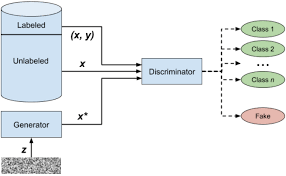

### Training Process
In a regular GAN, we train the Disciminator by computing the loss for D(x) and D(x*) and backpropagating the total loss to update the Disciminator's trainable parameters to minimise the loss. The Generator is trained by backpropagating the Discriminator's loss for D(x*), seeking to maximize it, so that the fake examples it synthesizes are misclassified as real.

To train the SGAN, in addition to D(x) and D(x*), we also have to compute the loss for the supervised training examples: D((x,y)). These losses correpond to to the dual learning objective that the SGAN Discriminator has to grapple with: distinguishing real examples from the fake ones while also learning to classify real examples to their correct classes. These dual objectives correspond to two kinds of losses: the supervised loss and the unsupervised loss.

### Training Objective
Most GAN variants goal is to produce realistic-looking data samples; hence, the Generator network has been of primary interest. The main purpose of the Discriminator network has been to help the Generator improve the quality of images it produces. At the end of the training, we often disregard the Discriminator and use only the fully trained Generator to create realistic-looking synthetic data.

In contract, in a SGAN, we care primarily about the Discriminator. The goal of the training process is to make this network into a semi-supervised classifier whose accuracy is as close as possible to a fully supervised classifier. The Generator's goal is to aid this process by serving as a source of additional information (the fake data it produces) that helps the Generator learn the relevant patterns in the data, enhancing its classification accuracy. At the end of training, the Generator gets discarded, and we use the trained Discriminator as a classifier.

### Implementations Notes
TODO

In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [2]:
# Model input dimensions
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset i.e. label types
num_classes = 10

### Dataset class
Although the MNIST training dataset has 50,000 labeled training images, we will use only a small fraction of them (specified by the `num_labeled` parameter) for training pretend that all the remaining ones are unlabeled. WWe accomplish this by sampling only from the first `num_labeled` images when generating batches of labeled data and from the remaining (50,000 - `num_labeled`) images when generating batches of unlabeled examples.

In [3]:
# Dataset class
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Preprocess training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Preprocess testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [4]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 100

dataset = Dataset(num_labeled)


In [5]:
# Generator - same as DCGAN

def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

### The Discriminator
TODO add implementation notes

In [6]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [7]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [8]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [10]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

In [11]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

In [20]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.004900]
1600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000197]
2400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000034]
3200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000098]
4000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000014]
4800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000014]
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000011]
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000003]
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000002]
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000002]


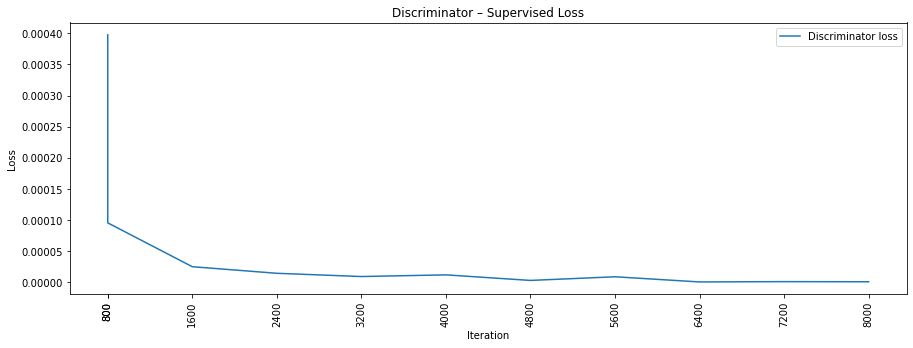

In [21]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [19]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)



# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)

print(discriminator_supervised.metrics_names)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 7ms/step - loss: 7.6534e-05 - accuracy: 1.0000
['loss', 'accuracy']
Training Accuracy: 100.00%


In [17]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 2s 7ms/step - loss: 1.6456 - accuracy: 0.6667
Test Accuracy: 66.67%
